# 3 - Semi-variance Estimators

This tutorial focuses on experimental variograms. It will guide you through the main semi-variance estimators available in `scikit-gstat`. Additionally, most of the parameters available for building an experimental variogram will be discussed.

**In this tutorial you will learn:**

* what estimators are available
* how they differ

In [1]:
from skgstat import Variogram, OrdinaryKriging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%env SKG_SUPPRESS=true

env: SKG_SUPPRESS=true


## 3.1 Load data

There are three prepared data sets in the `./data` folder. Each of them is a generated random field with different underlying spatial properties. We will use only the thrid one, but you can re-run all the examples with any of the other fields.

In [3]:
data1 = pd.read_csv('data/sample_matern_15.csv')
data2 = pd.read_csv('data/sample_matern_40.csv')
data3 = pd.read_csv('data/sample_spherical_noise.csv')

In [4]:
def plot_scatter(data, ax):
    art = ax.scatter(data.x, data.y, 50, c=data.z, cmap='plasma')
    plt.colorbar(art, ax=ax)

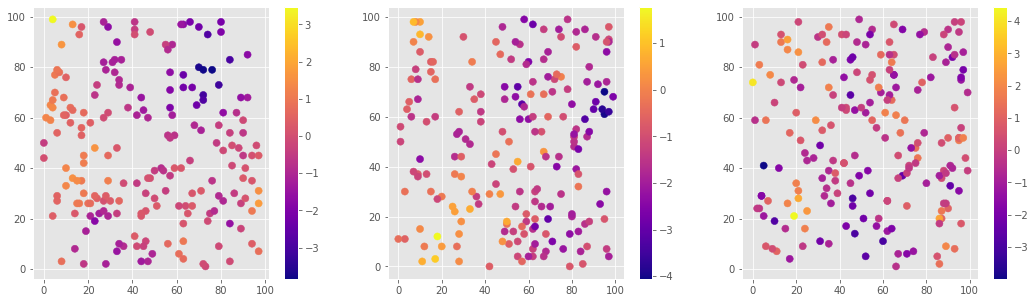

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for data, ax in zip((data1, data2, data3), axes.flatten()):
    plot_scatter(data, ax)

## 3.2 Comparing estimators

The default estimator configured in `Variogram` is the Mathéron estimator (Mathéron, 1963). It is defined like:


$$ \gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i+h}))^2 $$


where:

* $h$ is the distance lag
* $N(h)$ is the number of observation pairs in $h$-lag class
* $Z(x_i)$ is the observation at the $i$-th location $x$

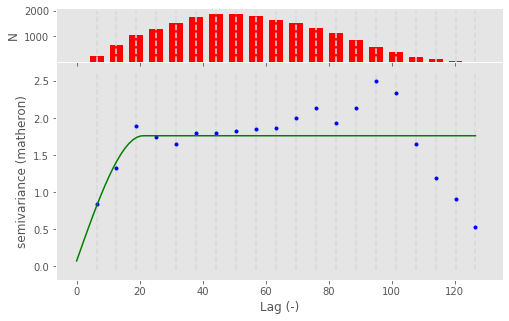

In [6]:
V1 = Variogram(data3[['x', 'y']].values, data3.z.values, normalize=False, n_lags=20, use_nugget=True)
V1.plot(show=False);

Following the histogram, we should set a `maxlag`. This property accepts a number $0 < maxlag < 1$ to set the `maxlag` to this ratio of the maximum separating distance. A number > 1 will use this at an absolute limit. You can also pass `'mean'` or `'median'`. This will calculate and set the mean or median of all distances in the distance matrix as `maxlag`.

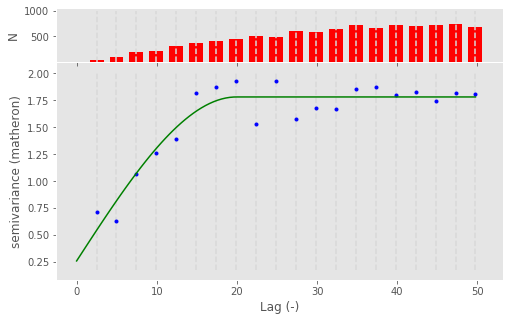

In [7]:
V1.maxlag = 'median'
V1.plot(show=False);

## 3.3 Alternative estimators

`scikit-gstat` implements more than only the Mathéron estimator. Setting `estimator='cressie'` will set the Cressie-Hawkins estimator. It is implemented as follows (Cressie and Hawkins, 1980):

$$ 2\gamma (h) = \frac{\left(\frac{1}{N(h)} \sum_{i=1}^{N(h)} |Z(x_i) - Z(x_{i+h})|^{0.5}\right)^4}
        {0.457 + \frac{0.494}{N(h)} + \frac{0.045}{N^2(h)}} $$

By setting `estimator='dowd'`, the Dowd estimator (Dowd, 1984) will be used:

$$ 2\gamma (h) = 2.198 * {median(Z(x_i) - Z(x_{i+h}))}^2 $$

Finally, `estimator='genton'` will set the Genton estimator (Genton, 1998):

$$ \gamma (h) = 2.2191\{|V_i(h) - V_j(h)|; i < j\}_{(k)} $$

with: 

$$ k = \binom{[N_h / 2] + 1}{2} $$

and:

$$ q = \binom{N_h}{2} $$


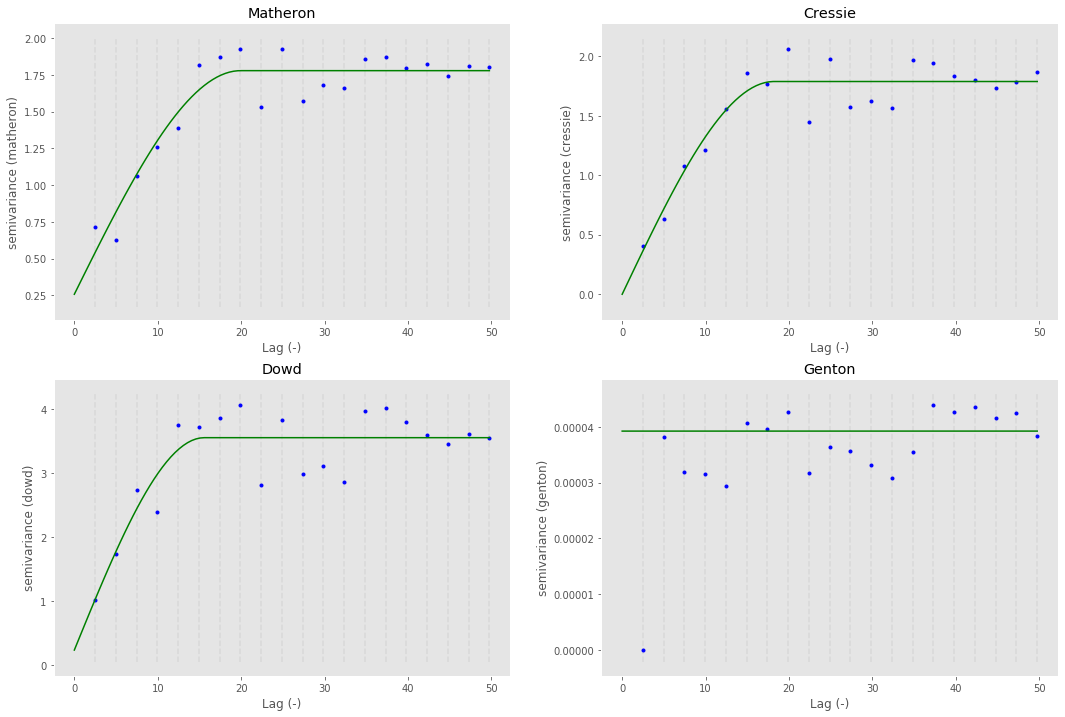

In [8]:
fig, _a = plt.subplots(2, 2, figsize=(18, 12))
axes = _a.flatten()
for ax, est in zip(axes, ('matheron', 'cressie', 'dowd', 'genton')):
    V1.estimator = est
    V1.plot(axes=ax, hist=False, show=False)
    ax.set_title(est.capitalize())

For Kriging, the difference on the first few lag classes is important, as no points will be used for estimation, that lies outside the range.

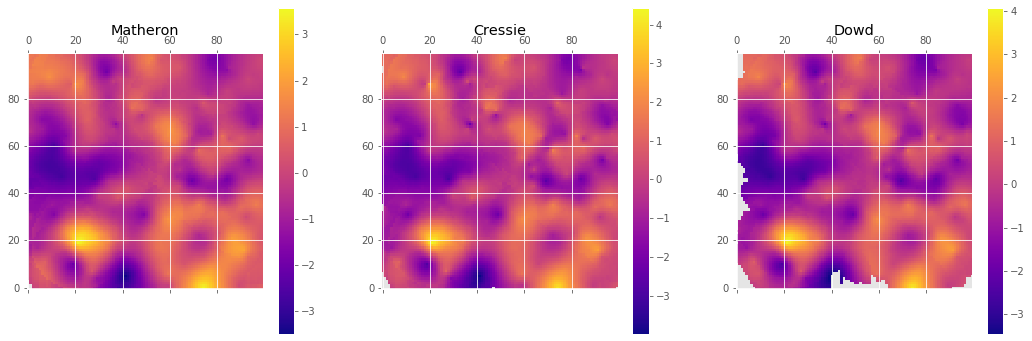

In [9]:
xx, yy = np.mgrid[0:99:100j, 0:99:100j]
fig, _a = plt.subplots(1, 3, figsize=(18, 6))
axes = _a.flatten()

for ax, est in zip(axes, ('matheron', 'cressie', 'dowd')):
    V1.estimator = est
    ok = OrdinaryKriging(V1, min_points=5, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    art = ax.matshow(field, origin='lower', cmap='plasma')
    plt.colorbar(art, ax=ax)
    ax.set_title(est.capitalize())

You can see from these results that the Cressie and the Dowd estimator pronounce the extreme values more. The original field is also in the `./data` folder. We can load it for comparison.

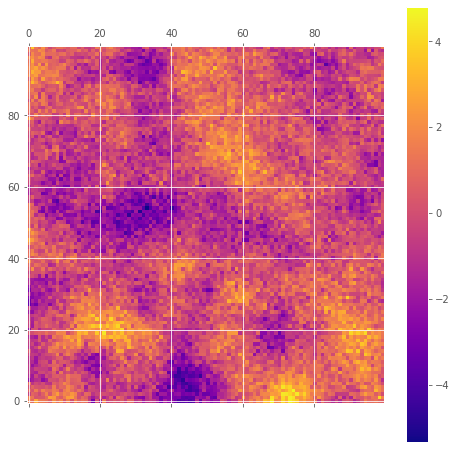

In [10]:
rf = np.loadtxt('data/rf_spherical_noise.txt')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
art = ax.matshow(rf, origin='lower', cmap='plasma')
plt.colorbar(art, ax=ax)

All three variograms were not able to capture the random variability. But the Matheron estimator was also not able to reconstruct the maxima from the random field.

## 3.4 References

Cressie, N., and D. Hawkins (1980): Robust estimation of the variogram. Math. Geol., 12, 115-125.

Dowd, P. A., (1984): The variogram and kriging: Robust and resistant estimators, in Geostatistics for Natural Resources Characterization. Edited by G. Verly et al., pp. 91 - 106, D. Reidel, Dordrecht.

Genton, M. G., (1998): Highly robust variogram estimation, Math. Geol., 30, 213 - 221.

Matheron, G. (1963). Principles of geostatistics. Economic Geology, 58(8), 1246–1266. https://doi.org/10.2113/gsecongeo.58.8.1246